In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, label_binarize

In [2]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/code/functions/')
from gis_processing import *
import pickle

In [3]:
data_dir = '/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/data'
model_dir = '/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/models'

In [4]:
weather_rename_dict = pd.read_pickle(os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl'))

In [5]:
target_df1 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_1.pkl'))
target_df2 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_2.pkl'))
target_df = target_df1.append(target_df2)
target_df.rename(columns = weather_rename_dict, inplace = True)

In [7]:
non_mod_cols = ['GRID_ID','month_id','MONTH','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', 'month_id_old', 'YEAR']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']

In [8]:
target_df.shape

(47388, 190)

### Perform PCA to see if we have any latent factors

In [9]:
X_features = target_df.copy()
for y in Y_cols + non_mod_cols:
    try:
        X_features.drop(y, inplace = True, axis =1)
    except:
        pass

In [10]:
X_features_scaled = scale(X_features)

In [11]:
pca = PCA()
pca_x = pca.fit(X_features_scaled)

In [12]:
pca_x.explained_variance_ratio_[0:20]

array([0.27236789, 0.15005973, 0.09594125, 0.08125559, 0.07320215,
       0.04960723, 0.03437999, 0.02726757, 0.02128068, 0.01908143,
       0.01681234, 0.01391132, 0.01364248, 0.01251452, 0.0113802 ,
       0.00932574, 0.00864207, 0.00728058, 0.00679026, 0.00629706])

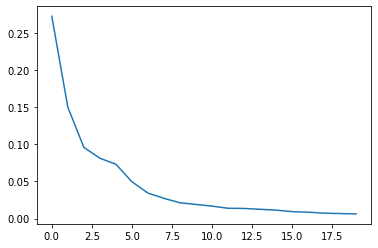

In [13]:
plt.plot(pca_x.explained_variance_ratio_[0:20])

In [24]:
pca_x.components_.shape

(170, 170)

In [14]:
pca_df = pd.DataFrame(pca_x.components_[0:20,].transpose(), columns = ["PC{}".format(i+1) for i in range(20)], \
                      index = X_features.columns)

In [15]:
pca_df.to_csv(os.path.join(data_dir, 'model_outputs/PCA_components_scaled.csv'))

### Transform

In [16]:
X_features_pca = pd.DataFrame(pca_x.transform(X_features_scaled), columns = X_features.columns)
X_features_pca['YEAR'] = target_df['YEAR']
X_train_pca = X_features_pca[X_features_pca['YEAR']< 2005]
X_test_pca = X_features_pca[X_features_pca['YEAR']>=2005]
Y_train_pca = target_df[target_df['YEAR']<2005]['Y_bin_new_fire_month']
Y_test_pca = target_df[target_df['YEAR']>=2005]['Y_bin_new_fire_month']

## Linear Regression

### Binary Classification

In [17]:
cs = [10**i for i in range(-4, 2)] 

In [18]:
LR_pca_bin = {}
LR_pca_score = {}
LR_pca_preds = {}
LR_pca_auc = {}
LR_pca_max_auc_ind = {}
for i in np.arange(5, 40, 5):
    LR_pca_bin[i] = {}
    LR_pca_score[i] = {}
    LR_pca_preds[i] = {}
    LR_pca_auc[i] = []
    for c in cs:
        LR_pca_bin[i][c] = LogisticRegression(C = c, class_weight = 'balanced').fit(X_train_pca.iloc[:,0:i], Y_train_pca)
        LR_pca_score[i][c] = LR_pca_bin[i][c].predict_proba(X_test_pca.iloc[:,0:i])[:,1]
        LR_pca_preds[i][c] = LR_pca_bin[i][c].predict(X_test_pca.iloc[:,0:i])
        ##Find best feature # + regularization combo
        fpr, tpr, thresholds = roc_curve(Y_test_pca, LR_pca_score[i][c])
        LR_pca_auc[i].append(auc(fpr, tpr))
    LR_pca_max_auc_ind[i] = LR_pca_auc[i].index(np.max(LR_pca_auc[i]))
print(LR_pca_max_auc_ind)

{5: 0, 10: 0, 15: 0, 20: 0, 25: 0, 30: 1, 35: 1}


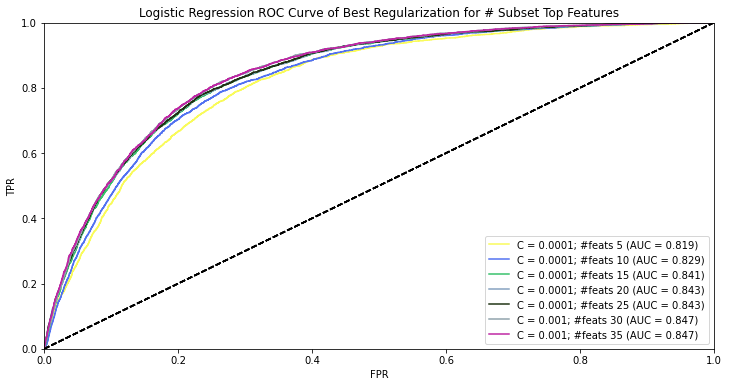

In [19]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize = (12,6))
for i in np.arange(5, 40, 5):
    c = cs[LR_pca_max_auc_ind[i]]
    fpr, tpr, thresholds = roc_curve(Y_test_pca, LR_pca_score[i][c])
    roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    col = (np.random.rand(), np.random.rand(), np.random.rand())

    #plot current model ROC curve
    plt.plot(fpr, tpr, color = col, label = f"C = {c}; " + f'#feats {i}' + ' (AUC = %0.3f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Logistic Regression ROC Curve of Best Regularization for # Subset Top Features')
    plt.legend(loc="lower right")
plt.show()

In [20]:
for i in np.arange(5, 40, 5):
    print(f"# PCs: {i}")
    c = cs[LR_pca_max_auc_ind[i]]
    print(f"# Regularization: {c}")
    cm = pd.DataFrame(confusion_matrix(Y_test_pca, LR_pca_preds[i][c], normalize = 'true'), columns = ['0', '1'],\
                  index = ['0','1'])
    print(cm)

# PCs: 5
# Regularization: 0.0001
          0         1
0  0.689111  0.310889
1  0.187233  0.812767
# PCs: 10
# Regularization: 0.0001
          0         1
0  0.660384  0.339616
1  0.156919  0.843081
# PCs: 15
# Regularization: 0.0001
          0         1
0  0.665585  0.334415
1  0.139444  0.860556
# PCs: 20
# Regularization: 0.0001
          0         1
0  0.674174  0.325826
1  0.146220  0.853780
# PCs: 25
# Regularization: 0.0001
          0         1
0  0.673363  0.326637
1  0.144793  0.855207
# PCs: 30
# Regularization: 0.001
          0         1
0  0.670596  0.329404
1  0.132311  0.867689
# PCs: 35
# Regularization: 0.001
          0         1
0  0.666110  0.333890
1  0.130528  0.869472


In [21]:
##output best PCA binary LR model
with open(os.path.join(model_dir, 'LR_15PCA_1990_2005.pkl'), 'wb') as handle:
    pickle.dump(LR_pca_bin[15][0.0001], handle)

### Multi-class

In [28]:
Y_train_multi = target_df[target_df['YEAR']<2016]['Y_max_new_fire_size_month']
Y_test_multi = target_df[target_df['YEAR']>=2016]['Y_max_new_fire_size_month']

In [41]:
#for multi-class problem have to binarize
y_test_multi_bin = label_binarize(Y_test_multi, classes=[0,1, 2, 3])
n_classes = y_test_multi_bin.shape[1]
y_test_multi_bin.shape
LR_multi_score[i][c][:,n].shape

(41052,)

In [ ]:
LR_multi = {}
LR_multi_score = {}
LR_multi_preds = {}
auc_by_class = {}
LR_multi_auc = {}
LR_multi_max_auc_ind = {}
LR_multi_max_auc = {}
for i in np.arange(5, 40, 5):
    LR_multi[i] = {}
    LR_multi_score[i] = {}
    LR_multi_preds[i] = {}
    auc_by_class[i] = {}
    LR_multi_auc[i] = []
    for c in cs:
        auc_by_class[i][c] = []
        LR_multi[i][c] = LogisticRegression(C = c, class_weight = 'balanced').fit(X_train_pca.iloc[:,0:i], \
                                            Y_train_multi.to_numpy().reshape(Y_train_multi.shape[0]))
        LR_multi_score[i][c] = LR_multi[i][c].predict_proba(X_test_pca.iloc[:,:i])
        LR_multi_preds[i][c] = LR_multi[i][c].predict(X_test_pca.iloc[:,:i])
        
        #Loop through the different classes and get average AUC across to find best c for given feature selection
        for n in range(n_classes):
            fpr, tpr, thresholds = roc_curve(y_test_multi_bin[:,n], LR_multi_score[i][c][:,n])
            auc_by_class[i][c].append(auc(fpr, tpr))
        LR_multi_auc[i].append(np.mean(auc_by_class[i][c]))
    LR_multi_max_auc[i] = np.max(LR_multi_auc[i])
    LR_multi_max_auc_ind[i] = LR_multi_auc[i].index(LR_multi_max_auc[i])

In [48]:
LR_multi_max_auc_ind

{5: 0, 10: 0, 15: 0, 20: 5, 25: 5, 30: 4, 35: 1}

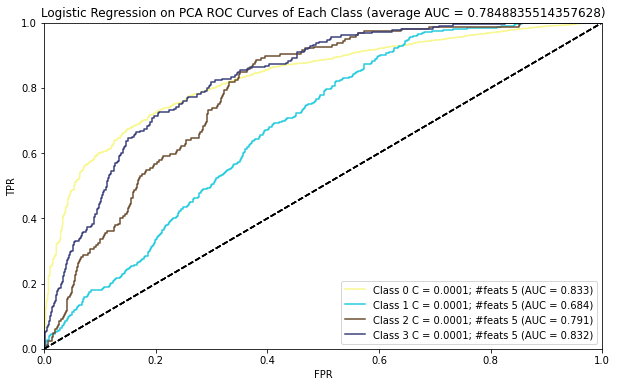

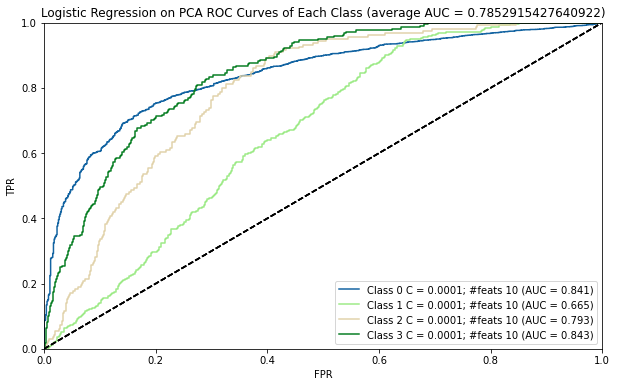

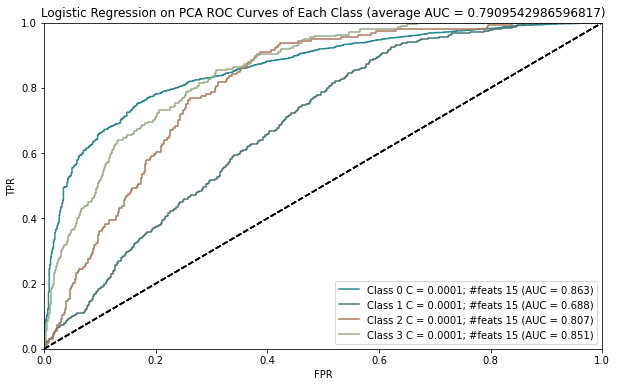

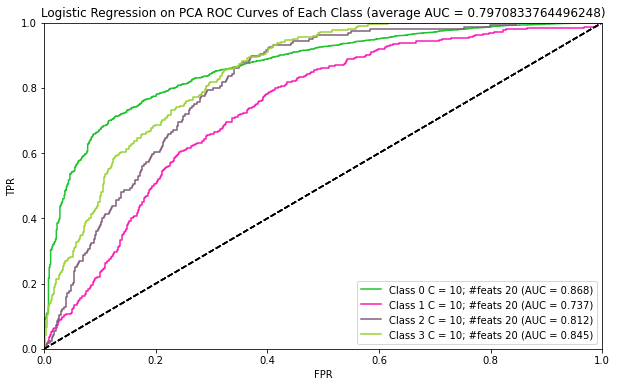

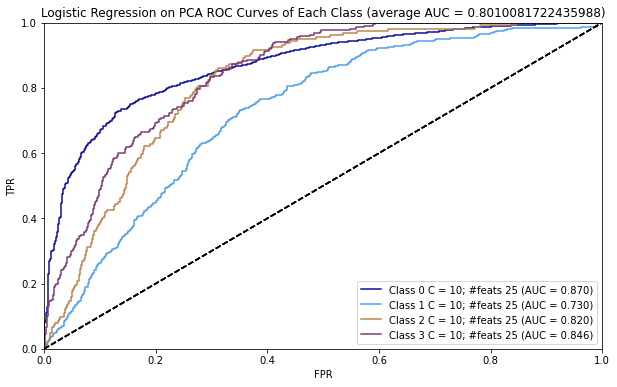

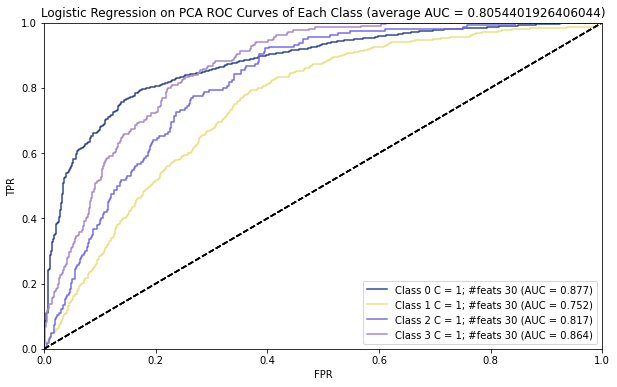

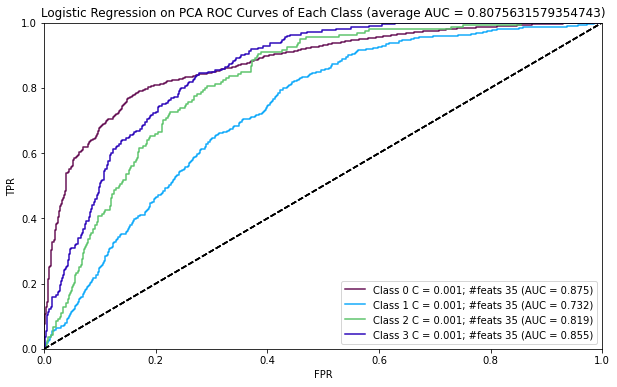

In [44]:
auc_by_class = []
for i in np.arange(5, 40, 5):
    c = cs[LR_multi_max_auc_ind[i]]
    plt.figure(figsize = (10,6))
    for n in range(n_classes):
        fpr, tpr, threshold = roc_curve(y_test_multi_bin[:,n], LR_multi_score[i][c][:,n])
        roc_auc = auc(fpr, tpr)
        auc_by_class.append(roc_auc)
        #chooses a random color for plotting
        col = (np.random.rand(), np.random.rand(), np.random.rand())
        #plot current model ROC curve
        plt.plot(fpr, tpr, color = col, label = f"Class {n} "+ f"C = {c}; " + f'#feats {i}' + ' (AUC = %0.3f)' % roc_auc) 
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend(loc="lower right")
    mean_auc = np.mean(auc_by_class)
    plt.title(f'Logistic Regression on PCA ROC Curves of Each Class (average AUC = {mean_auc})')
    plt.show()

In [47]:
Y_test_multi_np = Y_test_multi.to_numpy().reshape(Y_test_multi.shape[0])
for i in np.arange(5, 40, 5):
    print("# PCs: {}".format(i))
    c = cs[LR_multi_max_auc_ind[i]]
    print(pd.DataFrame(confusion_matrix(Y_test_multi, LR_multi_preds[i][c], labels = [0,1,2,3], normalize = 'true'), columns = ['0', '1', '2', '3'],
                  index = ['0', '1', '2', '3']))

# PCs: 5
          0         1         2         3
0  0.645057  0.130200  0.097965  0.126778
1  0.170426  0.192982  0.313283  0.323308
2  0.115854  0.109756  0.353659  0.420732
3  0.090909  0.100000  0.245455  0.563636
# PCs: 10
          0         1         2         3
0  0.611201  0.178822  0.093463  0.116514
1  0.142857  0.243108  0.315789  0.298246
2  0.085366  0.158537  0.329268  0.426829
3  0.045455  0.150000  0.272727  0.531818
# PCs: 15
          0         1         2         3
0  0.636953  0.150909  0.082838  0.129299
1  0.122807  0.273183  0.278195  0.325815
2  0.073171  0.146341  0.304878  0.475610
3  0.040909  0.136364  0.218182  0.604545
# PCs: 20
          0         1         2         3
0  0.623447  0.163875  0.083739  0.128939
1  0.107769  0.358396  0.270677  0.263158
2  0.073171  0.292683  0.268293  0.365854
3  0.036364  0.181818  0.195455  0.586364
# PCs: 25
          0         1         2         3
0  0.608860  0.220782  0.050423  0.119935
1  0.100251  0.518797  0.13

## SVM

### Binary classification

In [22]:
Y_train_pca = target_df[target_df['YEAR']<2005]['Y_bin_new_fire_month']
Y_test_pca = target_df[target_df['YEAR']>=2005]['Y_bin_new_fire_month']

In [23]:
linSVC_pca_bin = {}
linSVC_pca_score = {}
linSVC_pca_preds = {}
linSVC_pca_auc = {}
linSVC_pca_max_auc_ind = {}
for i in np.arange(5, 40, 5):
    linSVC_pca_bin[i] = {}
    linSVC_pca_score[i] = {}
    linSVC_pca_preds[i] = {}
    linSVC_pca_auc[i] = []
    for c in cs:
        linSVC_pca_bin[i][c] = LinearSVC(C = c, class_weight = 'balanced', dual = False).fit(X_train_pca.iloc[:,0:i], \
                                                                                             Y_train_pca)
        linSVC_pca_score[i][c] = linSVC_pca_bin[i][c].decision_function(X_test_pca.iloc[:,0:i])
        linSVC_pca_preds[i][c] = linSVC_pca_bin[i][c].predict(X_test_pca.iloc[:,0:i])
        ##Find best feature # + regularization combo
        fpr, tpr, thresholds = roc_curve(Y_test_pca, linSVC_pca_score[i][c])
        linSVC_pca_auc[i].append(auc(fpr, tpr))
    linSVC_pca_max_auc_ind[i] = linSVC_pca_auc[i].index(np.max(linSVC_pca_auc[i]))
print(linSVC_pca_max_auc_ind)

{5: 0, 10: 0, 15: 0, 20: 0, 25: 0, 30: 0, 35: 0}


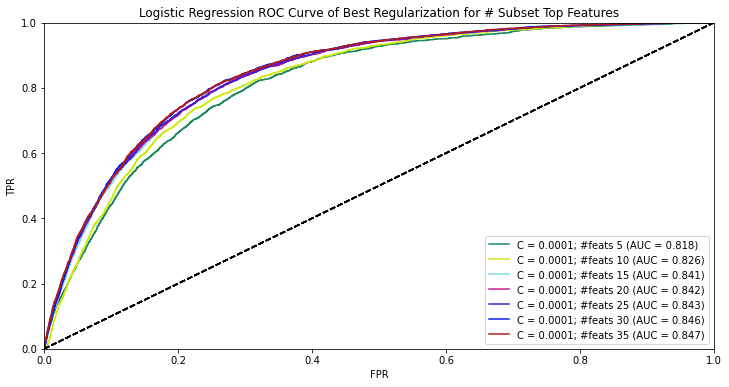

In [24]:
plt.figure(figsize = (12,6))
for i in np.arange(5, 40, 5):
    c = cs[linSVC_pca_max_auc_ind[i]]
    fpr, tpr, thresholds = roc_curve(Y_test_pca, linSVC_pca_score[i][c])
    roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    col = (np.random.rand(), np.random.rand(), np.random.rand())

    #plot current model ROC curve
    plt.plot(fpr, tpr, color = col, label = f"C = {c}; " + f'#feats {i}' + ' (AUC = %0.3f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Logistic Regression ROC Curve of Best Regularization for # Subset Top Features')
    plt.legend(loc="lower right")
plt.show()

In [57]:
Y_test_pca.shape

(6336,)

In [25]:
for i in np.arange(5, 40, 5):
    print(f"# PCs: {i}")
    c = cs[linSVC_pca_max_auc_ind[i]]
    print(f"# Regularization: {c}")
    cm = pd.DataFrame(confusion_matrix(Y_test_pca, linSVC_pca_preds[i][c], normalize = 'true'), columns = ['0', '1'],\
                  index = ['0','1'])
    print(cm)

# PCs: 5
# Regularization: 0.0001
          0         1
0  0.652367  0.347633
1  0.159415  0.840585
# PCs: 10
# Regularization: 0.0001
          0         1
0  0.605698  0.394302
1  0.120542  0.879458
# PCs: 15
# Regularization: 0.0001
          0         1
0  0.602691  0.397309
1  0.097718  0.902282
# PCs: 20
# Regularization: 0.0001
          0         1
0  0.612617  0.387383
1  0.104850  0.895150
# PCs: 25
# Regularization: 0.0001
          0         1
0  0.606509  0.393491
1  0.100214  0.899786
# PCs: 30
# Regularization: 0.0001
          0         1
0  0.606509  0.393491
1  0.092368  0.907632
# PCs: 35
# Regularization: 0.0001
          0         1
0  0.599446  0.400554
1  0.090585  0.909415


In [26]:
##output best SVM binary LR model
with open(os.path.join(model_dir, 'linSVC_15PCA_1990_2005.pkl'), 'wb') as handle:
    pickle.dump(linSVC_pca_bin[15][0.0001], handle)

### Multi-class

In [63]:
linSVC_multi = {}
linSVC_multi_score = {}
linSVC_multi_preds = {}
auc_by_class = {}
linSVC_multi_auc = {}
linSVC_multi_max_auc_ind = {}
linSVC_multi_max_auc = {}
for i in np.arange(5, 40, 5):
    linSVC_multi[i] = {}
    linSVC_multi_score[i] = {}
    linSVC_multi_preds[i] = {}
    auc_by_class[i] = {}
    linSVC_multi_auc[i] = []
    for c in cs:
        auc_by_class[i][c] = []
        linSVC_multi[i][c] = LogisticRegression(C = c, class_weight = 'balanced', dual = False).fit(X_train_pca.iloc[:,0:i], \
                                            Y_train_multi.to_numpy().reshape(Y_train_multi.shape[0]))
        linSVC_multi_score[i][c] = linSVC_multi[i][c].decision_function(X_test_pca.iloc[:,:i])
        linSVC_multi_preds[i][c] = linSVC_multi[i][c].predict(X_test_pca.iloc[:,:i])
        
        #Loop through the different classes and get average AUC across to find best c for given feature selection
        for n in range(n_classes):
            fpr, tpr, thresholds = roc_curve(y_test_multi_bin[:,n], linSVC_multi_score[i][c][:,n])
            auc_by_class[i][c].append(auc(fpr, tpr))
        linSVC_multi_auc[i].append(np.mean(auc_by_class[i][c]))
    linSVC_multi_max_auc[i] = np.max(linSVC_multi_auc[i])
    linSVC_multi_max_auc_ind[i] = linSVC_multi_auc[i].index(linSVC_multi_max_auc[i])

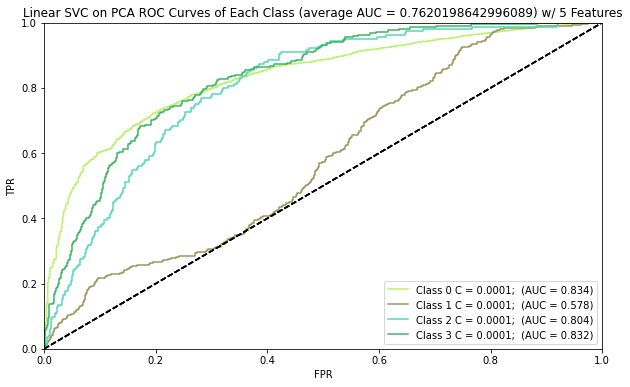

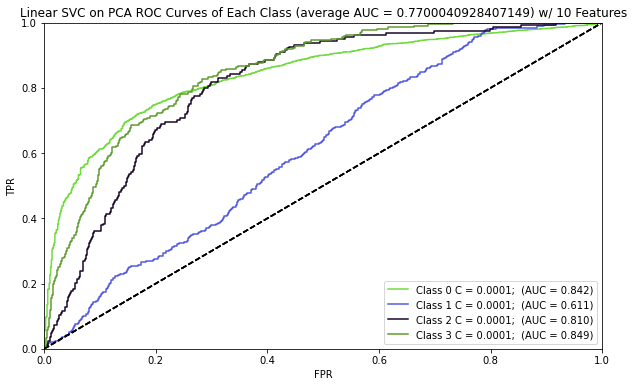

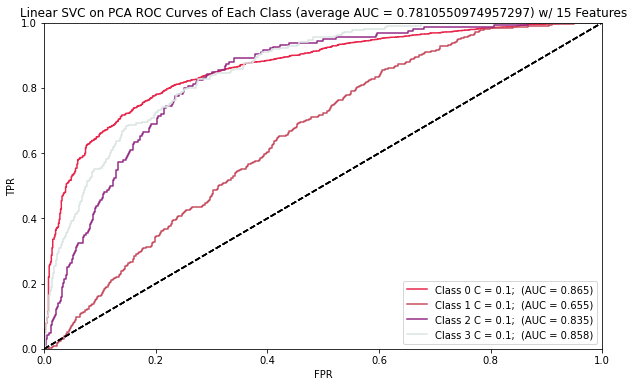

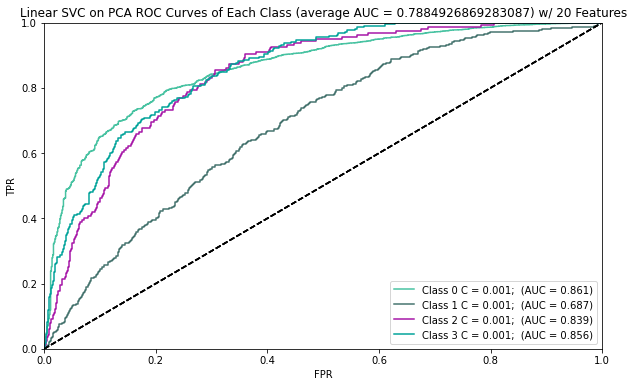

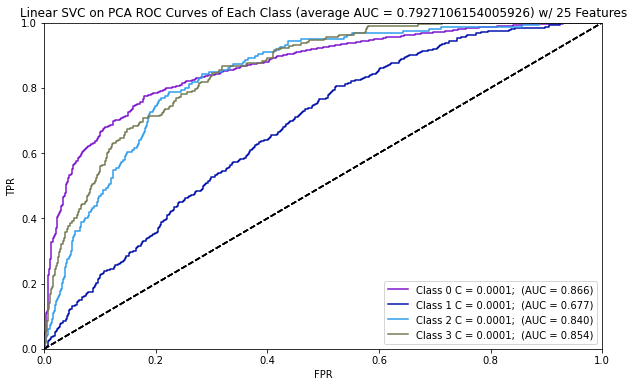

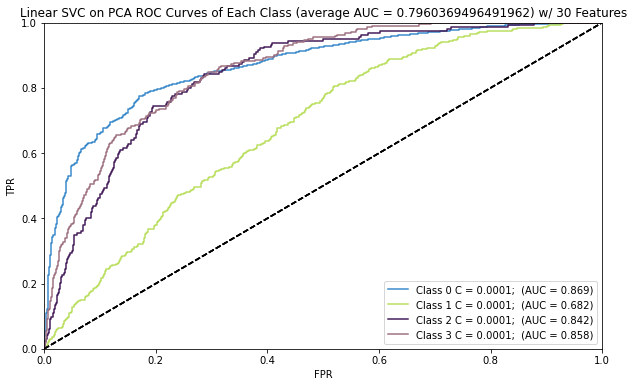

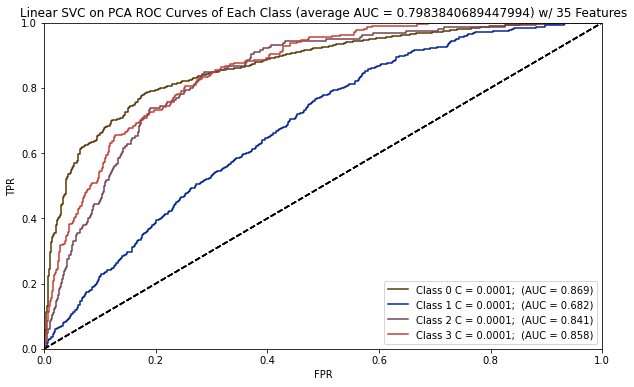

In [64]:
auc_by_class = []
for i in np.arange(5, 40, 5):
    c = cs[linSVC_multi_max_auc_ind[i]]
    plt.figure(figsize = (10,6))
    for n in range(n_classes):
        fpr, tpr, threshold = roc_curve(y_test_multi_bin[:,n], linSVC_multi_score[i][c][:,n])
        roc_auc = auc(fpr, tpr)
        auc_by_class.append(roc_auc)
        #chooses a random color for plotting
        col = (np.random.rand(), np.random.rand(), np.random.rand())
        #plot current model ROC curve
        plt.plot(fpr, tpr, color = col, label = f"Class {n} "+ f"C = {c}; " + ' (AUC = %0.3f)' % roc_auc) 
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend(loc="lower right")
    mean_auc = np.mean(auc_by_class)
    plt.title(f'Linear SVC on PCA ROC Curves of Each Class (average AUC = {mean_auc}) w/ {i} Features')
    plt.show()

In [65]:
Y_test_multi_np = Y_test_multi.to_numpy().reshape(Y_test_multi.shape[0])
for i in np.arange(5, 40, 5):
    print("# PCs: {}".format(i))
    c = cs[LR_multi_max_auc_ind[i]]
    print(pd.DataFrame(confusion_matrix(Y_test_multi, linSVC_multi_preds[i][c], labels = [0,1,2,3], normalize = 'true'), columns = ['0', '1', '2', '3'],
                  index = ['0', '1', '2', '3']))

# PCs: 5
          0         1         2         3
0  0.645057  0.130200  0.097965  0.126778
1  0.170426  0.192982  0.313283  0.323308
2  0.115854  0.109756  0.353659  0.420732
3  0.090909  0.100000  0.245455  0.563636
# PCs: 10
          0         1         2         3
0  0.611201  0.178822  0.093463  0.116514
1  0.142857  0.243108  0.315789  0.298246
2  0.085366  0.158537  0.329268  0.426829
3  0.045455  0.150000  0.272727  0.531818
# PCs: 15
          0         1         2         3
0  0.636953  0.150909  0.082838  0.129299
1  0.122807  0.273183  0.278195  0.325815
2  0.073171  0.146341  0.304878  0.475610
3  0.040909  0.136364  0.218182  0.604545
# PCs: 20
          0         1         2         3
0  0.623447  0.163875  0.083739  0.128939
1  0.107769  0.358396  0.270677  0.263158
2  0.073171  0.292683  0.268293  0.365854
3  0.036364  0.181818  0.195455  0.586364
# PCs: 25
          0         1         2         3
0  0.608860  0.220782  0.050423  0.119935
1  0.100251  0.518797  0.13